In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:99% !important;}
div.cell.code_cell.rendered{width:90%;}
div.CodeMirror {font-family:Consolas; font-size:20pt;}
div.output {font-size:18pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:19pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
span.toc-item-num{display:none;}
div.text_cell_render ul li{font-size:16pt;padding:5px;}
div.CodeMirror-lines > div {padding-left:10px;}
table.dataframe{font-size:19px;}
</style>
"""))

In [2]:
import numpy as np
import pandas as pd # read_csv, get_dumies(원핫인코딩)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split # 훈련셋과 시험셋 나누기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.activations import relu, softmax # activation='relu' 대신 사용
import matplotlib.pyplot as plt

- Red Wine 품질 등급 예측

```
1. 데이터 셋 확보 & 전처리
    독립변수, 종속변수 분리 -> 독립변수 스케일조정(StandardScaler), 종속변수 원핫인코딩(get_dummies), 
     훈련셋과 테스트셋 분리(train_test_split)
2. 모델 구성(입력11, 출력6) layer층 4
3. 모델 학습 과정 설정(다중분류에 맞는 설정)
4. 학습시키기 (callbacks이용)
5. 모델 평가 - 그래프, 평가(테스트셋), 교차표(crosstab)
6. 모델 저장 및 모델사용하기
```

## 1. 데이터 셋 확보 & 전처리
    독립변수, 종속변수 분리 -> 독립변수 스케일조정(StandardScaler), 종속변수 원핫인코딩(get_dummies) ->
     훈련셋과 테스트셋 분리(train_test_split)

In [3]:
# 데이터 읽어오기

# np.loadtxt('data/winequality-red.csv', delimiter=';', skiprows=1)
# np.genfromtxt('data/winequality-red.csv', delimiter=';', skip_header=1)

redwine = pd.read_csv('./data/winequality-red.csv', sep=';')

redwine.head()
# fixed acidity : 고정 산도
# volatile acidity : 휘발성 산도
# citric acid : 시트르산
# residual sugar : 잔류 당분
# chlorides : 염화물
# free sulfur dioxide : 자유 이산화황
# total sulfur dioxide : 총 이산화황
# density : 밀도
# pH
# sulphates : 황산염
# alcohol
# quality : 0 ~ 10(높을 수록 좋은 품질)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [19]:
# 독립변수, 종속변수 분리
X_redwine = redwine.iloc[:,:-1]
y_redwine = redwine.iloc[:,-1]
X_redwine.shape, y_redwine.shape

((1599, 11), (1599,))

In [5]:
X_redwine.sample()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
707,7.4,0.49,0.19,3.0,0.077,16.0,37.0,0.9966,3.37,0.51,10.5


In [6]:
y_redwine

0       5
1       5
2       5
3       6
4       5
       ..
1594    5
1595    6
1596    6
1597    5
1598    6
Name: quality, Length: 1599, dtype: int64

In [20]:
# 독립변수 스케일조정(StandardScaler)
scaler = StandardScaler()
scaler.fit(X_redwine.to_numpy()) # values와 to_numpy() 동일
scaled_X_redwine = scaler.transform(X_redwine.values)
scaled_X_redwine[:2]

array([[-0.52835961,  0.96187667, -1.39147228, -0.45321841, -0.24370669,
        -0.46619252, -0.37913269,  0.55827446,  1.28864292, -0.57920652,
        -0.96024611],
       [-0.29854743,  1.96744245, -1.39147228,  0.04341614,  0.2238752 ,
         0.87263823,  0.62436323,  0.02826077, -0.7199333 ,  0.1289504 ,
        -0.58477711]])

In [8]:
# 종속변수 원핫인코딩(get_dummies)
Y_redwine = pd.get_dummies(y_redwine).to_numpy() 
Y_redwine[:2]

array([[0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0]], dtype=uint8)

In [31]:
# 훈련셋과 테스트셋 분리(train_test_split) - 7:3분리
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X_redwine, 
                                Y_redwine,
                                test_size=0.3, 
                                random_state=1,
                                stratify=Y_redwine) # 층화추출(등급별 7:3으로 추출)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(1119, 11) (1119, 6) (480, 11) (480, 6)


In [32]:
# 층화추출을 하면 등급별 7:3으로  shuffle 되서 추출
np.c_[pd.Series(Y_train.argmax(axis=1)).value_counts(),
      pd.Series(Y_test.argmax(axis=1)).value_counts()]

array([[477, 204],
       [446, 192],
       [139,  60],
       [ 37,  16],
       [ 13,   5],
       [  7,   3]], dtype=int64)

## 2. 모델 구성(입력11, 출력6) layer층 4

In [11]:
model = Sequential()
model.add(Input(11)) # 의미있는 레이어가 아니고 input_dim만 지정
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=64, activation=relu))
model.add(Dropout(0.2))
model.add(Dense(units=16, activation=relu))
model.add(Dense(units=6, activation=softmax)) # 3 4 5 6 7 8 등급의 결과 합이 1
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                384       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                1040      
                                                                 
 dense_3 (Dense)             (None, 6)                 102       
                                                                 
Total params: 3,638
Trainable params: 3,638
Non-trainable params: 0
_________________________________________________________________


## 3. 모델 학습 과정 설정(다중분류에 맞는 설정)
## 4. 학습시키기(callbacks 이용)

In [12]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])

class CustomHistory(Callback): # on_epoch_end()는 각 에포크 종료시 자동 호출
    def __init__(self): # 생성자 함수
        self.epoch = 0
    def on_epoch_end(self, batch, logs={}):
        self.epoch += 1
        if self.epoch%5 ==0:
            print('epoch:{}, loss:{}, acc:{}, val_loss:{}, val_acc:{}'.\
                 format(self.epoch, 
                        logs.get('loss'), 
                        logs.get('accuracy'),
                        logs.get('val_loss'),
                        logs.get('val_accuracy')
                       ))
customHistory = CustomHistory()
earlyStropping = EarlyStopping(patience=20)
hist = model.fit(X_train, Y_train, epochs=100, batch_size=200, 
                 validation_split=0.2, 
                 callbacks=[earlyStropping, 
                           customHistory
                           ],
                verbose=0)

epoch:5, loss:1.265730381011963, acc:0.5720670223236084, val_loss:1.25290048122406, val_acc:0.5714285969734192
epoch:10, loss:1.0360674858093262, acc:0.5776536464691162, val_loss:1.077201008796692, val_acc:0.5803571343421936
epoch:15, loss:0.9709530472755432, acc:0.6134078502655029, val_loss:1.0284041166305542, val_acc:0.6026785969734192
epoch:20, loss:0.9415230751037598, acc:0.6134078502655029, val_loss:1.0196982622146606, val_acc:0.6116071343421936
epoch:25, loss:0.9286341667175293, acc:0.6167597770690918, val_loss:1.020064115524292, val_acc:0.6071428656578064
epoch:30, loss:0.9070735573768616, acc:0.6346368789672852, val_loss:1.0174192190170288, val_acc:0.6116071343421936
epoch:35, loss:0.8865436315536499, acc:0.6435754299163818, val_loss:1.0205719470977783, val_acc:0.6116071343421936
epoch:40, loss:0.8725653290748596, acc:0.6391061544418335, val_loss:1.014724612236023, val_acc:0.6160714030265808
epoch:45, loss:0.8508867621421814, acc:0.645810067653656, val_loss:1.0125997066497803, 

## 5. 모델 평가 - 그래프, 평가(테스트셋), 교차표(crosstab)

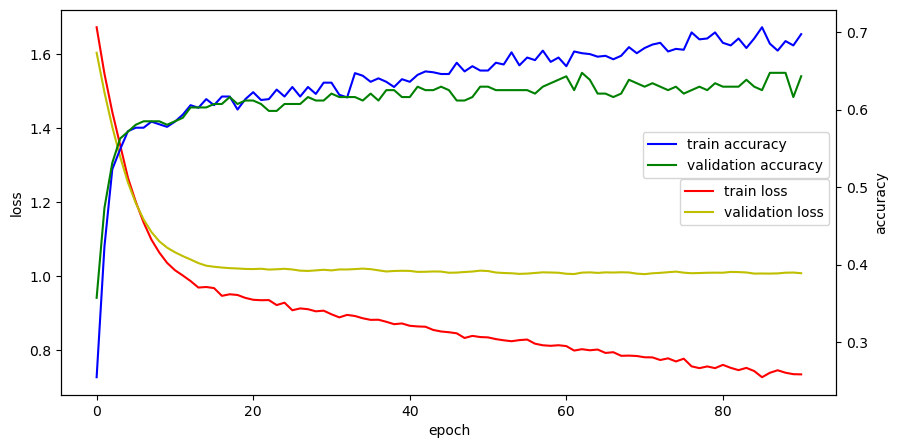

In [13]:
# 학습과정 표시하기(validation dataset 있는 경우)
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='validation accuracy')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [14]:
# 모델 평가하기
loss_and_acc = model.evaluate(X_test, Y_test, batch_size=32)
print('loss : ', loss_and_acc[0])
print('accuracy : ', loss_and_acc[1])

15/15 [==============================] - 0s 3ms/step - loss: 0.9655 - accuracy: 0.5896
loss :  0.9655091762542725
accuracy :  0.5895833373069763


In [15]:
# 7. 성능 지표(crosstab)
# pred = model.predict(X_test).argmax(axis=1)+3
pred = np.argmax(model.predict(X_test), axis=1)+3
# real = Y_test.argmax(axis=1) + 3
real = np.argmax(Y_test, axis=1) +3
cross_tab = pd.crosstab(real, pred)
cross_tab.index.name = "real"
cross_tab.columns.name = 'predict'
cross_tab

15/15 [==============================] - 0s 1ms/step


predict,4,5,6,7
real,,,,
3,1,2,0,0
4,1,9,6,0
5,0,144,59,1
6,0,60,120,12
7,0,2,40,18
8,0,0,3,2


## 6. 모델 저장 및 모델사용하기

In [16]:
model.save('model/winequality.h5')

In [17]:
redwine.sample()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
888,6.8,0.57,0.0,2.5,0.072,32.0,64.0,0.99491,3.43,0.56,11.2,6


In [18]:
input_data = np.array([[10.5, 0.39, 0.46, 2.2, 0.075, 14.0, 27.0, 0.99598, 3.06, 0.84,11.4]])
scaled_input_data = scaler.transform(input_data)
np.argmax(model.predict(scaled_input_data), axis=1) + 3

1/1 [==============================] - 0s 46ms/step


array([7], dtype=int64)